In [70]:
	
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

%matplotlib inline

In [71]:
plt.rcParams["figure.figsize"] = (12,9)


In [72]:
wine_data = load_wine()

wine_df = pd.DataFrame(
    data=wine_data.data,
    columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


/Users/anshujoshi/anaconda3/envs/Data_Science/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


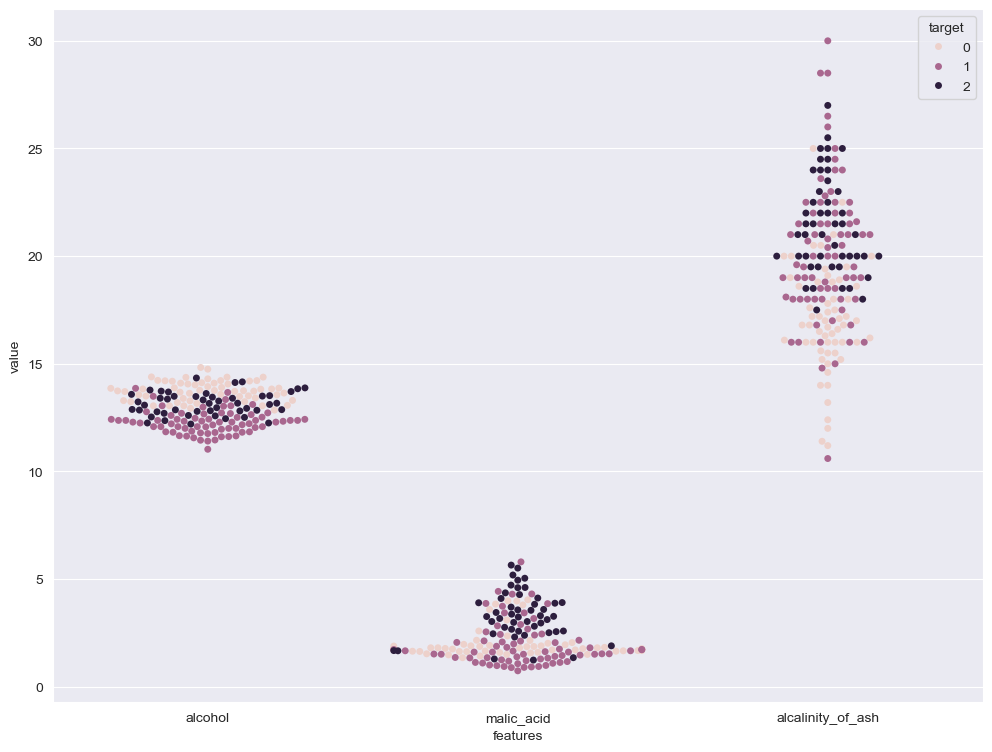

In [73]:
from seaborn import swarmplot

data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']],
                       id_vars='target',
                       var_name='features',
                       value_name='value')

swarmplot(data=data_to_plot, x='features', y='value', hue='target');

In [74]:
wine_df['target'].value_counts()


target
1    71
0    59
2    48
Name: count, dtype: int64

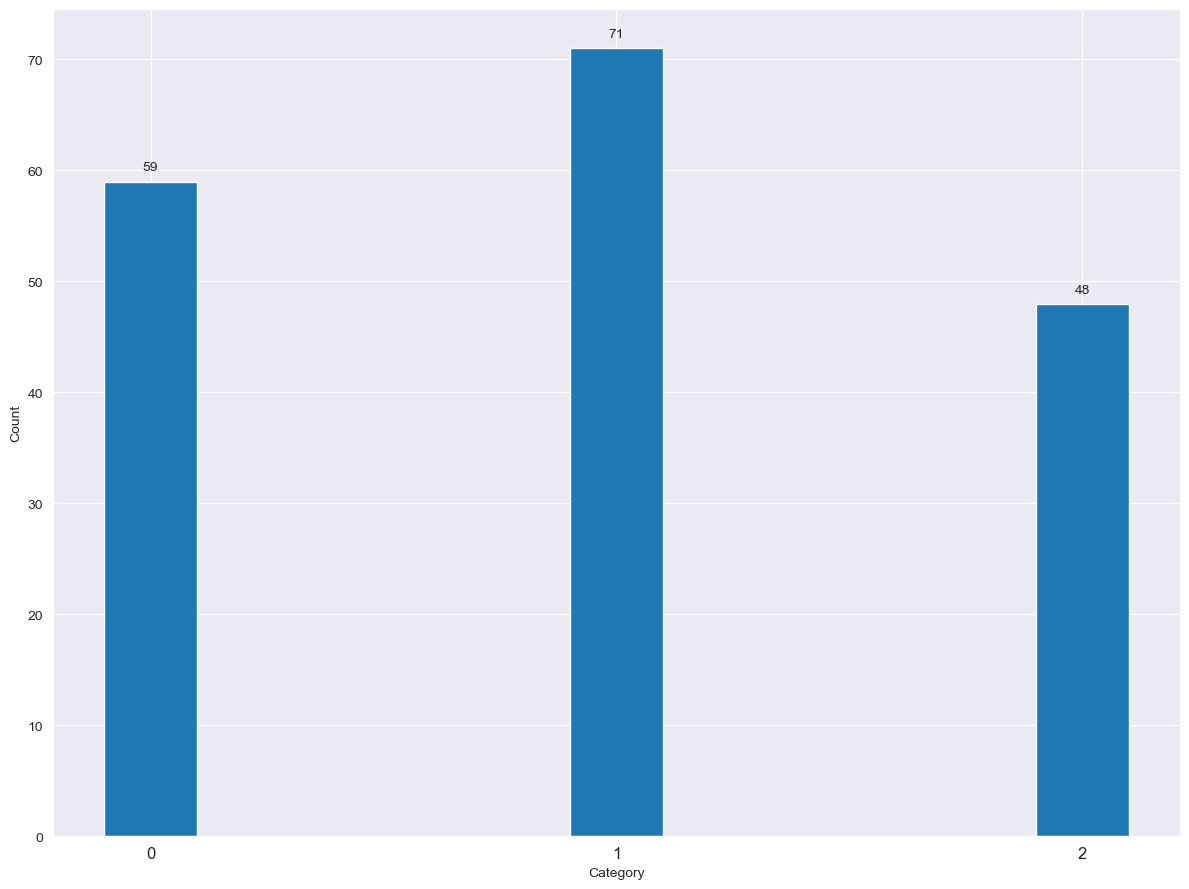

In [75]:
fig, ax = plt.subplots()

x = [0, 1, 2]
y = [59, 71, 48]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2])
ax.set_xticklabels([0,1,2], fontsize=12)

for index, value in enumerate(y):
    plt.text(x=int(index), y=value+1, s=str(value), ha='center')
    
plt.tight_layout()

In [76]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [117]:
comparision = {}

In [118]:
print(X_train.shape)
print(X_test.shape)

(124, 13)
(54, 13)


In [119]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Initialize classifier
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gbc.fit(X_train, y_train)

# Make predictions
preds = gbc.predict(X_test)

# Evaluate the model using the F1-score
base_result = round(f1_score(y_test, preds, average='weighted'), 3)
comparision['Base Model'] = base_result
print(base_result)

0.908


#### Baseline Model

So to beat score is .90

#### 1. VARIANCE THRESHOLD:
    1. Features with low variance can be removed from the feature set
    2. Nieve method for feature selecrtion
    3. All features need to be properly scaled 

In [82]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
X_train_v1.var(axis=0)


alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [83]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

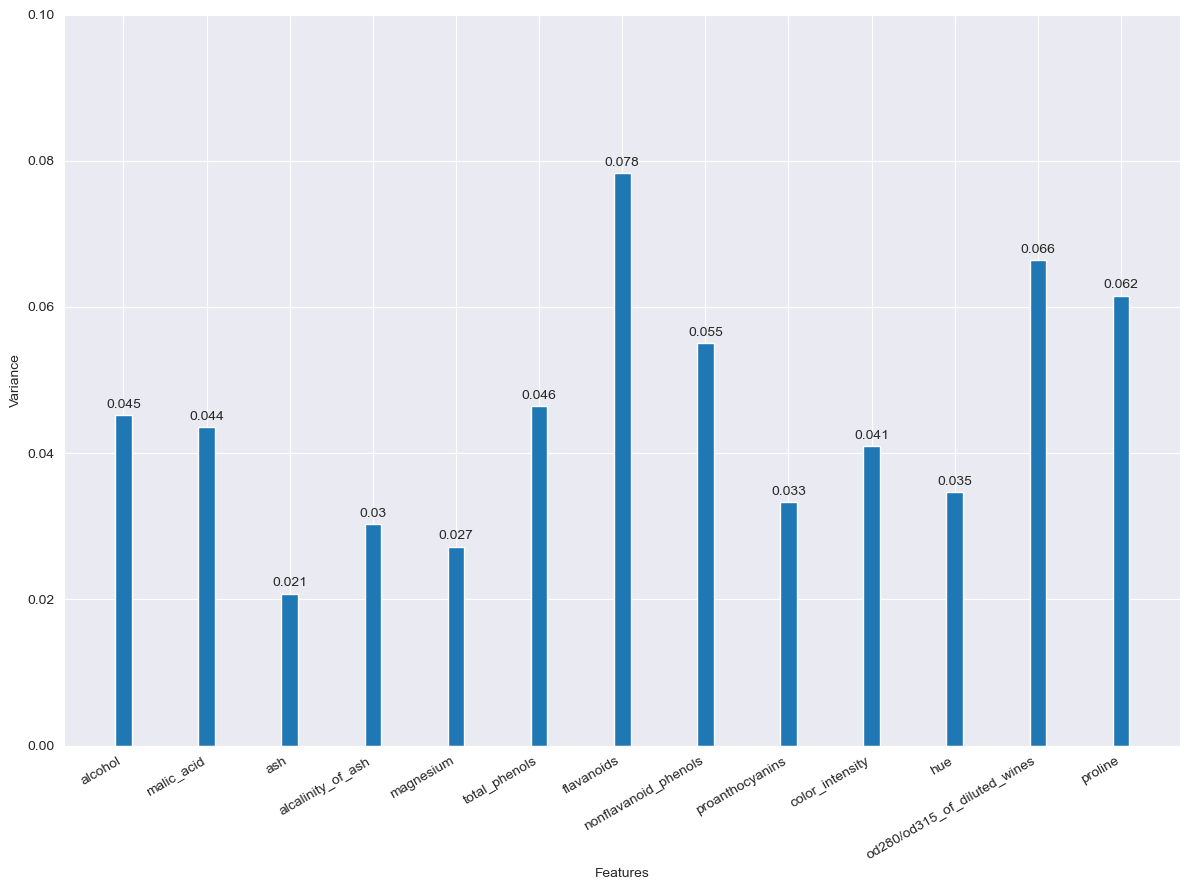

In [84]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()


 Getting rid of anything with variance <.30

In [120]:
sel_X_train_v1 = X_train_v1.drop(['ash', 'magnesium'], axis=1)
sel_X_test_v1 = X_test_v1.drop(['ash', 'magnesium'], axis=1)

gbc.fit(sel_X_train_v1, y_train)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)
comparision['Varince TH'] = f1_score_var
print(f1_score_var)

0.963


Weighted avg score .96 which is greater than baseline model 

#### Top K-best feature filter 

In [87]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

from sklearn.feature_selection import mutual_info_classif,SelectKBest
f1_scores = []


for i in range(1,14):
    selector = SelectKBest(mutual_info_classif,k=i)
    selector.fit(X_train,y_train)
    
    sel_X_train = selector.transform(X_train)
    sel_X_test = selector.transform(X_test)
    gbc.fit(sel_X_train,y_train)
    preds = gbc.predict(sel_X_test)

    result = round(f1_score(y_test_v2, preds, average='weighted'),3)
    f1_scores.append(result)
f1_scores
                   
    

[0.759,
 0.926,
 0.981,
 0.981,
 0.981,
 0.981,
 0.981,
 0.963,
 0.963,
 0.945,
 0.945,
 0.908,
 0.908]

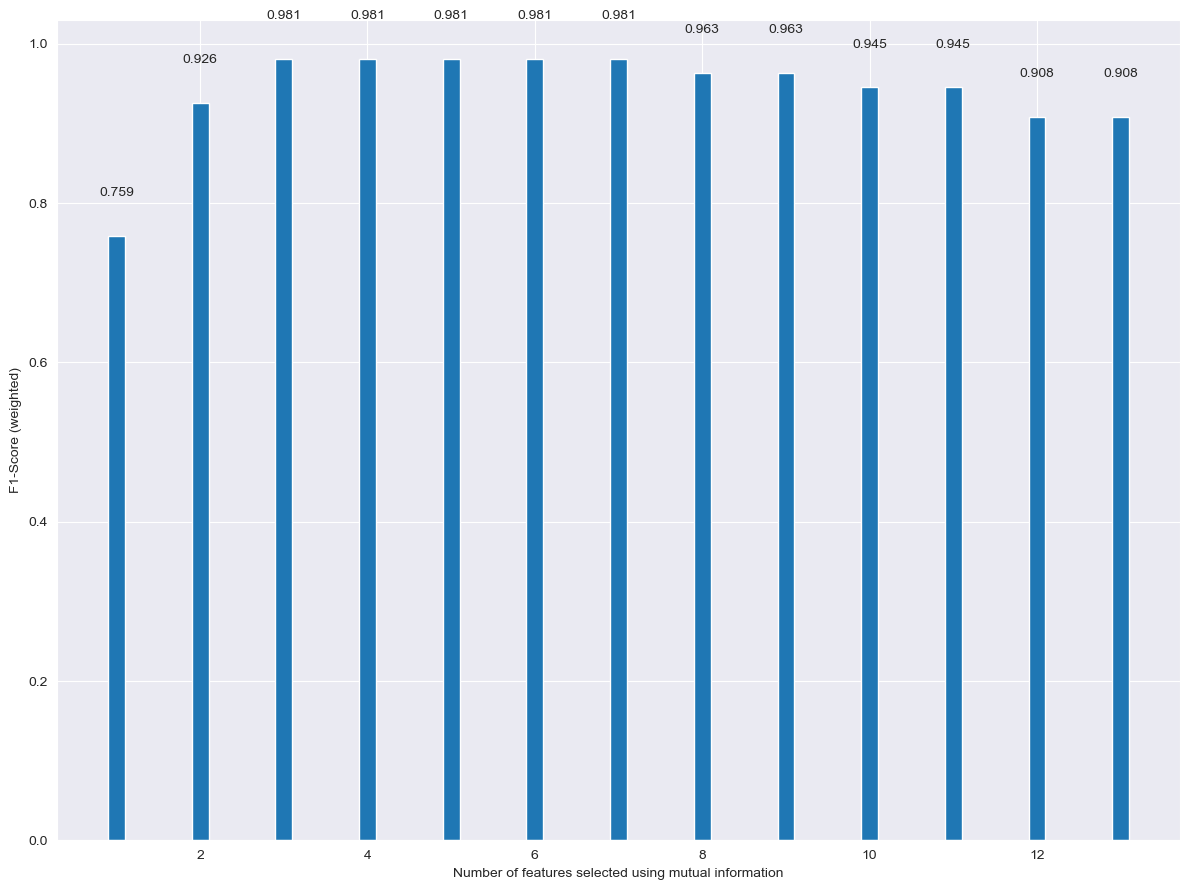

In [97]:
fig, ax = plt.subplots()

x = np.arange(1, 14)
y = f1_scores

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score (weighted)')

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()

Using top 3 gives best result

In [121]:
selector = SelectKBest(mutual_info_classif,k=3)
selector.fit(X_train_v2,y_train_v2)

X_train_v2_selected = selector.transform(X_train_v2,)
X_test_v2_selected = selector.transform(X_test_v2)

gbc.fit(X_train_v2_selected,y_train_v2)
preds = gbc.predict(X_test_v2_selected)

result = round(f1_score(y_test_v2,preds,average='weighted'),3)
comparision['3-best Selector'] = result
result

0.981

In [122]:
mask = selector.get_support()
X_train_v2.columns[mask]

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')

Model perfomace significantly better at K=3  that is .98. So taking smaller features at improve performance as well as accuracy of the model.

#### Recursive Feature Elimination
